In [203]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import seaborn as sns
import scipy.special as sp
import sklearn.datasets as datasets
import sklearn.linear_model as lm
import sklearn.ensemble as en
import sklearn.tree as tree
import econml
import importlib

#### data generation packages
import strawman_edge
import strawman_center
import all_linear

#### main packages
import characterize
import estimate_atte as est
import learn_w as learn
import black

importlib.reload(est)
importlib.reload(learn)

%load_ext jupyter_black

The jupyter_black extension is already loaded. To reload it, use:
  %reload_ext jupyter_black


## Experiments

### Strawman (Easy Mode) Example with under represented samples on edge
$P(S=1 \mid X) = expit( 0.25 - 2\left((X_0 > 0.5) (X_0 < 1) (X_1 > 0.5) (X_1 < 1)\right) )$ \
$Y(0) = 10 sin(\pi X_0 X_1) + 20 (X_2 - 0.5)^2 + 10 X_3 + 5 X_4 + \epsilon$ \
$Y(1) = Y(0) + log(Y(0) + 1)$

(2.5724337024478223, 0.8056096440614813)
(2.7158190343685957, 0.03578070003649376)
(2.694105549043027, 0.06483286846611812)
2.715024374105188


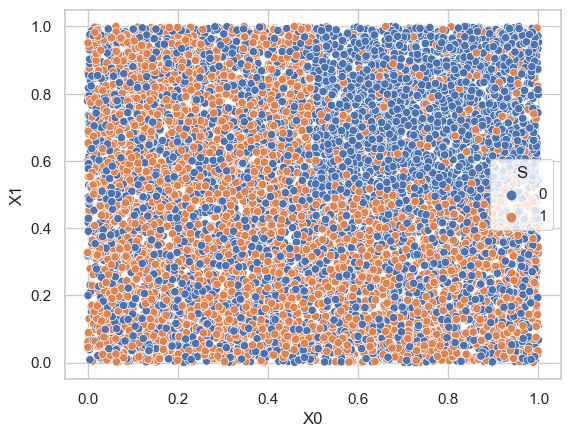

In [180]:
df, Y = strawman_edge.get_data(n=10000, seed=0)
sns.scatterplot(x="X0", y="X1", hue="S", data=df)

atte_sim, atte_se_sim = est.estimate_sim(
    data=df, outcome="Yobs", treatment="T", sample="S"
)
atte_out_reg, atte_se_outreg = est.estimate_out_reg(
    data=df, outcome="Yobs", treatment="T", sample="S"
)
atte_dml, atte_se_dml = est.estimate_dml(
    data=df, outcome="Yobs", treatment="T", sample="S"
)
print((atte_sim, atte_se_sim))
print((atte_out_reg, atte_se_outreg))
print((atte_dml, atte_se_dml))
print((Y["Y1"].loc[df["S"] == 0] - Y["Y0"].loc[df["S"] == 0]).mean())

Text(0.5, 0, 'ATTE')

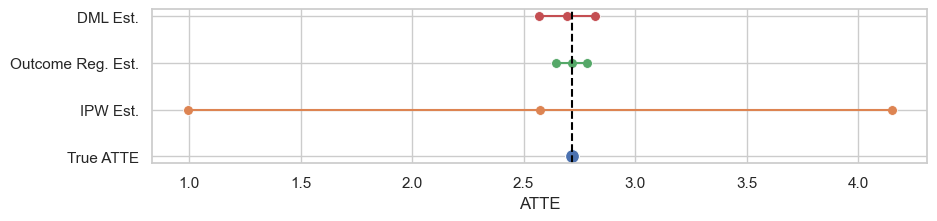

In [181]:
sns.set(style="whitegrid")
fig, ax = plt.subplots(figsize=(10, 2))
sns.lineplot(
    x=[(Y["Y1"].loc[df["S"] == 0] - Y["Y0"].loc[df["S"] == 0]).mean()],
    y=[0],
    ax=ax,
)
sns.scatterplot(
    x=[(Y["Y1"].loc[df["S"] == 0] - Y["Y0"].loc[df["S"] == 0]).mean()],
    y=[0],
    ax=ax,
    s=100,
)
sns.lineplot(
    x=[atte_sim - (1.96 * atte_se_sim), atte_sim, atte_sim + (1.96 * atte_se_sim)],
    y=[1, 1, 1],
    ax=ax,
)
sns.scatterplot(
    x=[atte_sim - (1.96 * atte_se_sim), atte_sim, atte_sim + (1.96 * atte_se_sim)],
    y=[1, 1, 1],
    ax=ax,
    s=50,
)

sns.lineplot(
    x=[
        atte_out_reg - (1.96 * atte_se_outreg),
        atte_out_reg,
        atte_out_reg + (1.96 * atte_se_outreg),
    ],
    y=[2, 2, 2],
    ax=ax,
)
sns.scatterplot(
    x=[
        atte_out_reg - (1.96 * atte_se_outreg),
        atte_out_reg,
        atte_out_reg + (1.96 * atte_se_outreg),
    ],
    y=[2, 2, 2],
    ax=ax,
    s=50,
)

sns.lineplot(
    x=[
        atte_dml - (1.96 * atte_se_dml),
        atte_dml,
        atte_dml + (1.96 * atte_se_dml),
    ],
    y=[3, 3, 3],
    ax=ax,
)
sns.scatterplot(
    x=[
        atte_dml - (1.96 * atte_se_dml),
        atte_dml,
        atte_dml + (1.96 * atte_se_dml),
    ],
    y=[3, 3, 3],
    ax=ax,
    s=50,
)

plt.axvline(
    (Y["Y1"].loc[df["S"] == 0] - Y["Y0"].loc[df["S"] == 0]).mean(), c="black", ls="--"
)

plt.yticks([0, 1, 2, 3], ["True ATTE", "IPW Est.", "Outcome Reg. Est.", "DML Est."])
plt.xlabel("ATTE")

Optimization terminated successfully    (Exit mode 0)
            Current function value: 1.2349622288037099
            Iterations: 1
            Function evaluations: 11
            Gradient evaluations: 1
(1.2349622288037099, 0.15339477524281392, 1.096702651813293, 2.5288959594943434)


<Axes: xlabel='X0', ylabel='X1'>

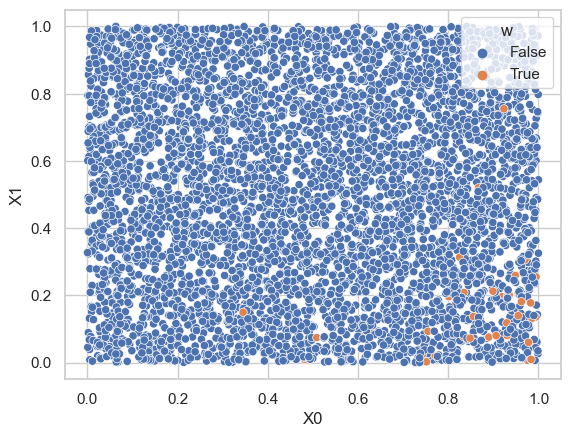

In [182]:
result, atte, se, atte_unpruned, se_unpruned, f, testing_data = learn.linear_opt(
    data=df, outcome="Yobs", treatment="T", sample="S"
)
print((se, se_unpruned, atte, atte_unpruned))

sns.scatterplot(data=testing_data, x="X0", y="X1", hue="w")

(0.12478104906689934, 0.13032031821519466, 2.537876640900922, 2.5845488467604154)


/Users/harshparikh/Library/CloudStorage/OneDrive-JohnsHopkins/GitHub/fuse/learn_w.py:179: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(np.sum(w * vsq) / (np.sum(w * (1 - S))) ** 2)


[Text(0.3333333333333333, 0.875, 'X1 <= 0.613\nsquared_error = 0.125\nsamples = 5000\nvalue = 0.853'),
 Text(0.16666666666666666, 0.625, 'squared_error = 0.068\nsamples = 3072\nvalue = 0.927'),
 Text(0.5, 0.625, 'X8 <= 0.45\nsquared_error = 0.195\nsamples = 1928\nvalue = 0.735'),
 Text(0.3333333333333333, 0.375, 'squared_error = 0.111\nsamples = 836\nvalue = 0.873'),
 Text(0.6666666666666666, 0.375, 'X0 <= 0.317\nsquared_error = 0.233\nsamples = 1092\nvalue = 0.63'),
 Text(0.5, 0.125, 'squared_error = 0.112\nsamples = 335\nvalue = 0.872'),
 Text(0.8333333333333334, 0.125, 'squared_error = 0.249\nsamples = 757\nvalue = 0.523')]

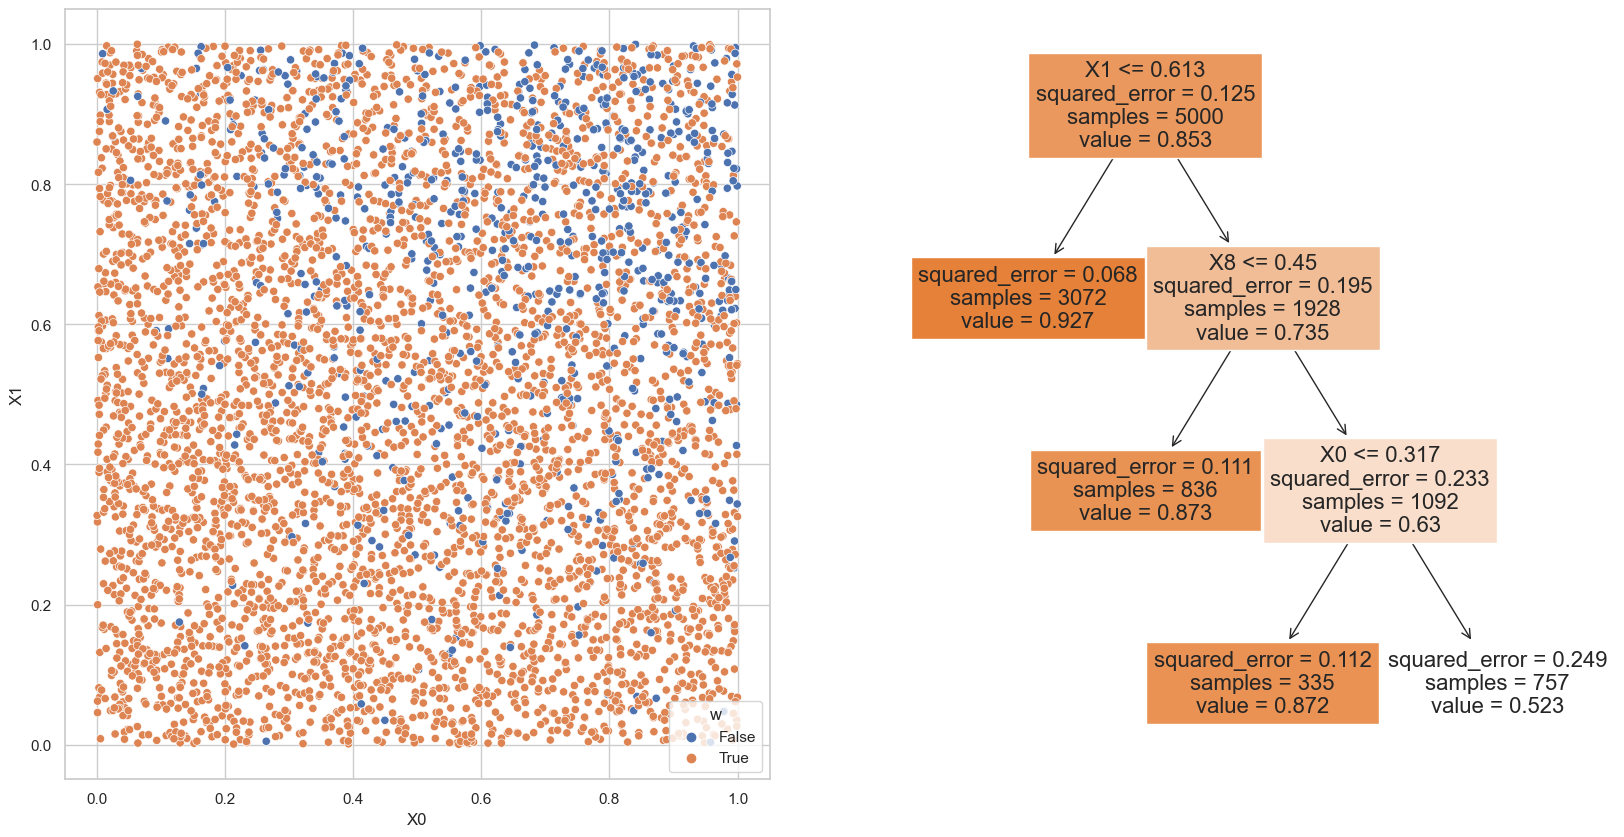

In [197]:
result, atte, se, atte_unpruned, se_unpruned, f, testing_data = learn.kmeans_opt(
    data=df, outcome="Yobs", treatment="T", sample="S", k=20
)
print((se, se_unpruned, atte, atte_unpruned))

fig, ax = plt.subplots(ncols=2, figsize=(20, 10))
sns.scatterplot(data=testing_data, x="X0", y="X1", hue="w", ax=ax[0])

tree.plot_tree(
    f,
    feature_names=testing_data.drop(columns=["Yobs", "T", "S", "w"]).columns,
    ax=ax[1],
    filled=True,
)

In [311]:
importlib.reload(learn)
w_tree, D, testing_data = learn.tree_opt(
    data=df, outcome="Yobs", treatment="T", sample="S", leaf_proba=2**-17, seed=7
)

<Axes: xlabel='X0', ylabel='X1'>

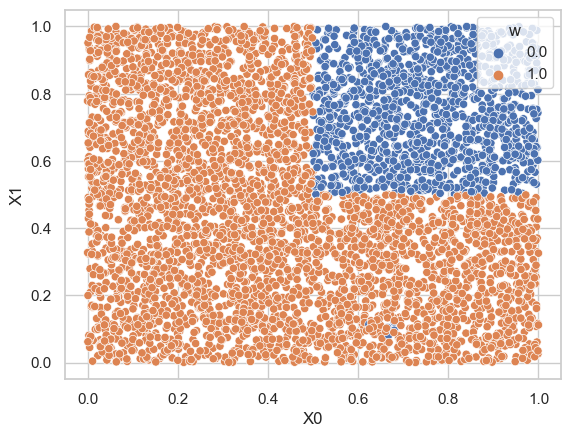

In [312]:
sns.scatterplot(x="X0", y="X1", data=D, hue="w")

In [310]:
w_tree

{'node': 'X0',
 'split': 0.49999615106093104,
 'left_tree': {'node': 'leaf',
  'w': 1,
  'local objective': 0.12265540395869895,
  'depth': 1},
 'right_tree': {'node': 'X1',
  'split': 0.5001790439497042,
  'left_tree': {'node': 'X1',
   'split': 0.25023765193620734,
   'left_tree': {'node': 'X3',
    'split': 0.49931004816867675,
    'left_tree': {'node': 'X1',
     'split': 0.12527583812866816,
     'left_tree': {'node': 'X1',
      'split': 0.06282357132847866,
      'left_tree': {'node': 'X0',
       'split': 0.7623796725925037,
       'left_tree': {'node': 'X0',
        'split': 0.6438771503831087,
        'left_tree': {'node': 'X4',
         'split': 0.5618313523841167,
         'left_tree': {'node': 'X1',
          'split': 0.029757540877417277,
          'left_tree': {'node': 'X3',
           'split': 0.24780064174125777,
           'left_tree': {'node': 'X9',
            'split': 0.38943055288112555,
            'left_tree': {'node': 'leaf',
             'w': 0,
             '

### All Linear (Moderate Mode)
$Y(0) = \beta_0^T X + \epsilon$ \
$Y(1) = Y(0) + \beta_1^T X + \epsilon$ \
$P(S=1 \mid X ) = expit( \alpha_0^T X )$

In [ ]:
df, Y, coef = all_linear.get_data(n=5000, seed=0)

display(pd.DataFrame(coef, index=["coef. X%d" % (i) for i in range(20)]).T)

#### plot scatter plot of X0 vs X1 and mark the region that is undersampled in experiment (truth)
sns.set(style="whitegrid")

alpha = [
    10,
    0,
]  # we are only interested in identifying under sampled subpopulation and not in heterogeneity
method = "match"
n_neighbors = 100
p = 1
characterization_depth = 3
smallest_k = 100
matched_groups, result, tau, M, df_result, m_tree = characterize.characterize(
    df,
    alpha=alpha,
    method=method,
    n_neighbors=n_neighbors,
    p=p,
    characterization_depth=characterization_depth,
    smallest_k=smallest_k,
)

#### plot scatter plot of X0 vs X1 and mark the points in the region that is highlighted as undersampled in experiment (est)
fig, ax = plt.subplots(figsize=(10, 8), ncols=2, nrows=2)
sns.scatterplot(x="X4", y="X6", hue="S", data=df, alpha=0.75, ax=ax[0, 0])
sns.scatterplot(
    x="X4",
    y="X6",
    hue="flagged",
    data=df_result,
    ax=ax[0, 1],
)

gs = ax[1, 0].get_gridspec()
for axs in ax[1, :]:
    axs.remove()
axbig = fig.add_subplot(gs[1, :])

#### characterization of the under-sampled space
plot_tree = tree.plot_tree(
    m_tree,
    filled=True,
    ax=axbig,
    feature_names=df_result.drop(columns=["Yobs", "T", "S", "flagged"]).columns,
)

### Strawman (Hard Mode) Example with under represented samples in the middle
$P(S=1 \mid X) = expit( - 3\left((X_0 > 0.4) (X_0 < 0.6) (X_1 > 0.4) (X_1 < 0.6)\right) )$ \
$Y(0) = 10 sin(\pi X_0 X_1) + 20 (X_2 - 0.5)^2 + 10 X_3 + 5 X_4 + \epsilon$ \
$Y(1) = Y(0) + log(Y(0) + 1)$

In [ ]:
df, Y = strawman_center.get_data(n=5000, seed=0)

#### plot scatter plot of X0 vs X1 and mark the region that is undersampled in experiment (truth)
sns.set(style="whitegrid")

alpha = [5, 1]
method = "match"
n_neighbors = 100
p = np.inf
characterization_depth = 2
smallest_k = 100

matched_groups, result, tau, M, df_result, m_tree = characterize.characterize(
    df, alpha=alpha, method=method, n_neighbors=n_neighbors, p=p
)

#### plot scatter plot of X0 vs X1 and mark the points in the region that is highlighted as undersampled in experiment (est)
fig, ax = plt.subplots(figsize=(15, 7), ncols=3)
sns.scatterplot(x="X0", y="X1", hue="S", data=df, alpha=0.75, ax=ax[0])
ax[0].add_patch(
    Rectangle((0.4, 0.4), 0.2, 0.2, color="black", ls="--", alpha=0.2, fill=True)
)

sns.scatterplot(
    x="X0",
    y="X1",
    hue="flagged",
    data=df_result,
    ax=ax[1],
)
ax[1].add_patch(
    Rectangle((0.4, 0.4), 0.2, 0.2, color="black", ls="--", alpha=0.2, fill=True)
)


#### characterization of the under-sampled space

plot_tree = tree.plot_tree(
    m_tree,
    filled=True,
    ax=ax[2],
    feature_names=df_result.drop(columns=["Yobs", "T", "S", "flagged"]).columns,
)

In [ ]:
df, Y = strawman_center.get_data(n=5000, seed=0)

#### plot scatter plot of X0 vs X1 and mark the region that is undersampled in experiment (truth)
sns.set(style="whitegrid")
fig, ax = plt.subplots(figsize=(10, 10))
sns.scatterplot(x="X0", y="X1", hue="S", data=df, alpha=0.75, ax=ax)
ax.add_patch(
    Rectangle((0.4, 0.4), 0.2, 0.2, color="black", ls="--", alpha=0.2, fill=True)
)

alpha = [100, 0]
method = "match"
n_neighbors = 10
p = np.inf
characterization_depth = 3
smallest_k = 100
matched_groups, result, tau, M, df_result, m_tree = characterize.characterize(
    df,
    alpha=alpha,
    method=method,
    n_neighbors=n_neighbors,
    p=p,
    characterization_depth=characterization_depth,
    smallest_k=smallest_k,
)

#### plot scatter plot of X0 vs X1 and mark the points in the region that is highlighted as undersampled in experiment (est)
fig, ax = plt.subplots(figsize=(10, 10))
sns.scatterplot(x="X0", y="X1", data=df, alpha=0.75, ax=ax)
sns.scatterplot(
    x="X0",
    y="X1",
    hue="flagged",
    data=df_result,
    ax=ax,
)
ax.add_patch(
    Rectangle((0.4, 0.4), 0.2, 0.2, color="black", ls="--", alpha=0.2, fill=True)
)


#### characterization of the under-sampled space
fig, ax = plt.subplots(figsize=(10, 10))
plot_tree = tree.plot_tree(
    m_tree,
    filled=True,
    ax=ax,
    feature_names=df_result.drop(columns=["Yobs", "T", "S", "flagged"]).columns,
)